# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

EPS = 1.0e-7

In [2]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
results_dir = "/content/gdrive/MyDrive/university CI"


In [4]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

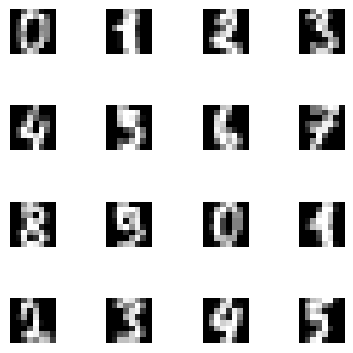

In [5]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [6]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [7]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # Get the predicted class label by finding the index of the maximum value along the class dimension
        y_pred = torch.argmax(self.classnet(x), dim=1).long()

        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # Compute the negative log-likelihood loss
        # PLEASE FILL IN
        loss = self.nll(self.classnet(x), y.long())
        # Apply the reduction based on the specified reduction mode
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()
# Implement a neural network (NN) classifier.
# class ClassifierNeuralNet(nn.Module):
#    def __init__(self, classnet):
#        super(ClassifierNeuralNet, self).__init__()
#        # We provide a sequential module with layers and activations
#        self.classnet = classnet
#        # The loss function (the negative log-likelihood)
#        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

#    # This function classifies an image x to a class.
#    # The output must be a class label (long).
#    def classify(self, x):
#        # Pass the input through the classnet
#        output = self.classnet(x)
#        # Apply log-softmax to get the log-probabilities
#        log_probs = F.log_softmax(output, dim=1)
#        # Get the predicted class label as the index with the highest log-probability
#        _, predicted_class = log_probs.max(dim=1)
#        return predicted_class

#    # This function is crucial for a module in PyTorch.
#    # In our framework, this class outputs a value of the loss function.
#    def forward(self, x, y, reduction="avg"):
#        # Pass the input through the classnet
#        output = self.classnet(x)
#        # Apply log-softmax to get the log-probabilities
#        log_probs = F.log_softmax(output, dim=1)
#        # Compute the negative log-likelihood loss
#        loss = self.nll(log_probs, y)
#        # Apply reduction
#        if reduction == "sum":
#            loss = loss.sum()
#        elif reduction == "avg":
#            loss = loss.mean()
#        return loss


**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:**

NLLLoss = $-\Sigma_ilogp(y_i|x_i, \theta)$

It calcuates how well the predicted probabilities of the correct labels correspond to the actual labels in the training data. The loss is calculated for each training example, and the individual losses are then added together to get the overall loss.

**Question 2 (0-0.5pt):** taht is okay because because the logarithm doesnt change the very most probable label, only the change probability to the log probability.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 Evaluation

In [9]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [10]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [11]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [12]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
# print(f"Feature example shape: {example.shape}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [13]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [14]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=1.6319823782784597, val ce=0.5171428571428571
Epoch: 10, val nll=0.19493964331490654, val ce=0.04857142857142857
Epoch: 20, val nll=0.13878458772386823, val ce=0.02857142857142857
Epoch: 30, val nll=0.11880304881504604, val ce=0.022857142857142857
Epoch: 40, val nll=0.1061174876349313, val ce=0.022857142857142857
-> FINAL PERFORMANCE: nll=0.2790262555115975, ce=0.07829977628635347


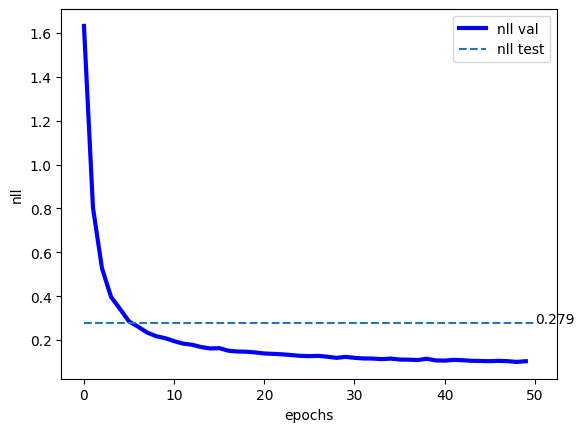

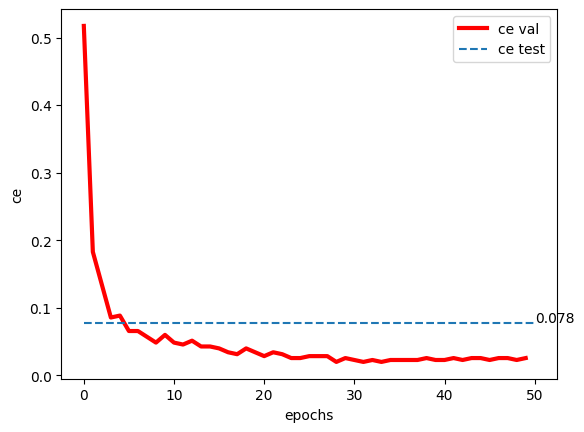


-> START classifier_cnn
Epoch: 0, val nll=0.6911827305385044, val ce=0.22
Epoch: 10, val nll=0.12464676856994629, val ce=0.025714285714285714
Epoch: 20, val nll=0.09059071438653128, val ce=0.017142857142857144
Epoch: 30, val nll=0.07262020996638707, val ce=0.02
Epoch: 40, val nll=0.07006244318825858, val ce=0.02
-> FINAL PERFORMANCE: nll=0.17408087429584274, ce=0.049217002237136466


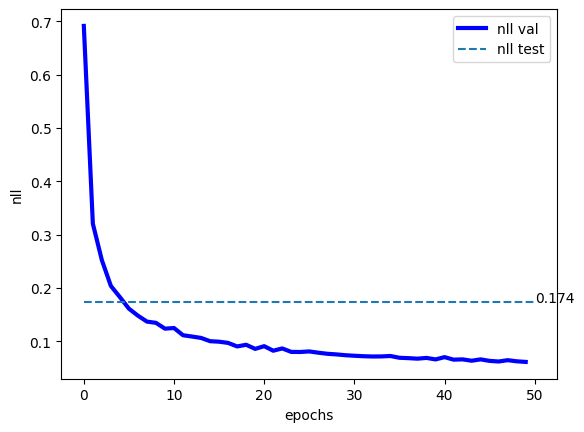

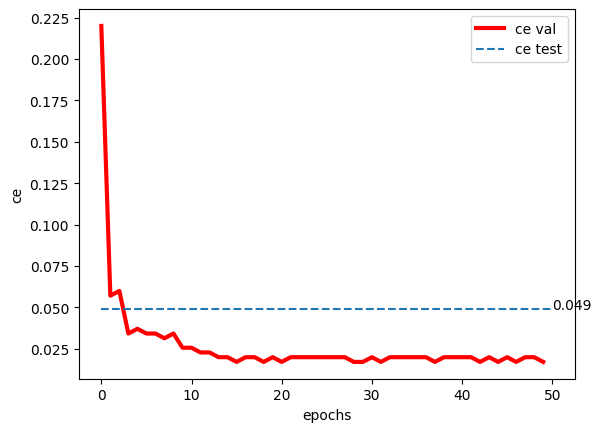

In [41]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# # We will run two models: MLP and CNN
# names = ["classifier_mlp", "classifier_cnn"]

# # loop over models
# for name in names:
#     print("\n-> START {}".format(name))
#     # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
#     if name == "classifier_mlp":
#         name = name + "_M_" + str(M)
#     elif name == "classifier_cnn":
#         name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

#     # Create a folder if necessary
#     result_dir = os.path.join(results_dir, "results", name + "/")

#     # =========
#     # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
#     result_dir = "./"  # (current folder)
#     # =========
#     if not (os.path.exists(result_dir)):
#         os.mkdir(result_dir)

#     # MLP
#     if name[0:14] == "classifier_mlp":
#         # =========
#         # GRADING:
#         # 0
#         # 0.5pt if properly implemented
#         # =========
#         # ------
#         # PLEASE FILL IN:
#         # classnet = nn.Sequential(...)
#         #
#         # You are asked here to propose your own architecture
#         # NOTE: Please remember that the output must be LogSoftmax!
#         # ------
#         pass

#     # CNN
#     elif name[0:14] == "classifier_cnn":
#         # =========
#         # GRADING:
#         # 0
#         # 0.5pt if properly implemented
#         # =========
#         # ------
#         # PLEASE FILL IN:
#         # classnet = nn.Sequential(...)
#         #
#         # You are asked here to propose your own architecture
#         # NOTE: Plese note that the images are represented as vectors, thus, you must
#         # use Reshape(size) as the first layer, and Flatten() after all convolutional
#         # layers and before linear layers.
#         # NOTE: Please remember that the output must be LogSoftmax!
#         # ------
#         pass

#     # Init ClassifierNN
#     model = ClassifierNeuralNet(classnet)

#     # Init OPTIMIZER (here we use ADAMAX)
#     optimizer = torch.optim.Adamax(
#         [p for p in model.parameters() if p.requires_grad == True],
#         lr=lr,
#         weight_decay=wd,
#     )

#     # Training procedure
#     nll_val, error_val = training(
#         name=result_dir + name,
#         max_patience=max_patience,
#         num_epochs=num_epochs,
#         model=model,
#         optimizer=optimizer,
#         training_loader=training_loader,
#         val_loader=val_loader,
#     )

#     # The final evaluation (on the test set)
#     test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
#     # write the results to a file
#     f = open(result_dir + name + "_test_loss.txt", "w")
#     f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
#     f.close()
#     # create curves
#     plot_curve(
#         result_dir + name,
#         nll_val,
#         file_name="_nll_val_curve.pdf",
#         ylabel="nll",
#         test_eval=test_loss,
#     )
#     plot_curve(
#         result_dir + name,
#         error_val,
#         file_name="_ca_val_curve.pdf",
#         ylabel="ce",
#         color="r-",
#         test_eval=test_error,
#     )
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]


# loop over models
for name in names:
   print("\n-> START {}".format(name))
   # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
   if name == "classifier_mlp":
       name = name + "_M_" + str(M)
   elif name == "classifier_cnn":
       name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)


   # Create a folder if necessary
   result_dir = os.path.join(results_dir, "results", name + "/")


   # =========
   # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
   result_dir = "./"  # (current folder)
   # =========
   if not (os.path.exists(result_dir)):
       os.mkdir(result_dir)


   # MLP
   # MLP
   # MLP
# MLP
   if name[0:14] == "classifier_mlp":
       classnet = nn.Sequential(
           nn.Flatten(),  # Flatten the input tensor
           nn.Linear(D, M),  # Linear layer with M neurons
           nn.ReLU(),  # ReLU activation function
           nn.Linear(M, K),  # Linear layer with K output neurons
           nn.LogSoftmax(dim=1)  # LogSoftmax activation for output probabilities
       )








# CNN
   elif name[0:14] == "classifier_cnn":


          classnet = nn.Sequential(
            Reshape(size=(1, 8, 8)),  # Reshape the input tensor
            nn.Conv2d(1, num_kernels, kernel_size=2, stride=1, padding=1),  # Convolutional layer
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=1),  # Max pooling layer
            Flatten(),  # Flatten the tensor
            nn.Linear(num_kernels * 8 * 8, K),  # Linear layer with K output neurons
            nn.LogSoftmax(dim=1)  # LogSoftmax activation for output probabilities
)



   # Init ClassifierNN
   model = ClassifierNeuralNet(classnet)


   # Init OPTIMIZER (here we use ADAMAX)
   optimizer = torch.optim.Adamax(
       [p for p in model.parameters() if p.requires_grad == True],
       lr=lr,
       weight_decay=wd,
   )


   # Training procedure
   nll_val, error_val = training(
       name=result_dir + name,
       max_patience=max_patience,
       num_epochs=num_epochs,
       model=model,
       optimizer=optimizer,
       training_loader=training_loader,
       val_loader=val_loader,
   )


   # The final evaluation (on the test set)
   test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
   # write the results to a file
   f = open(result_dir + name + "_test_loss.txt", "w")
   f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
   f.close()
   # create curves
   plot_curve(
       result_dir + name,
       nll_val,
       file_name="_nll_val_curve.pdf",
       ylabel="nll",
       test_eval=test_loss,
   )
   plot_curve(
       result_dir + name,
       error_val,
       file_name="_ca_val_curve.pdf",
       ylabel="ce",
       color="r-",
       test_eval=test_error,
   )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: The CNN exhibits a higher level of accuracy in convergence compared to the MLP. By examining the red line representing the MLP, we observe that it converges to 0.078, whereas the CNN classifier achieves a convergence of 0.049. Notably, the CNN's improved accuracy can be attributed to its utilization of log-softmax for calculating the loss. This results in higher accuracies for the CNN, indicated by a final NNLis of 0.174. Consequently, when detecting and classifying digits, the digits are more likely to be correctly classified to the right features in MLP instead of CNN. This further emphasizes that the larger the loss, the more likely photos are not correctly assigned to the correct features.

#### MLP

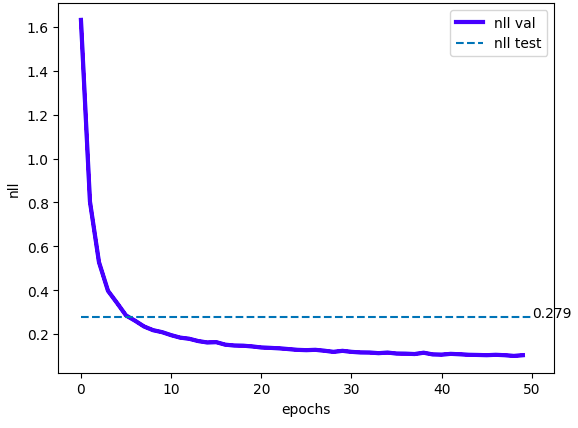

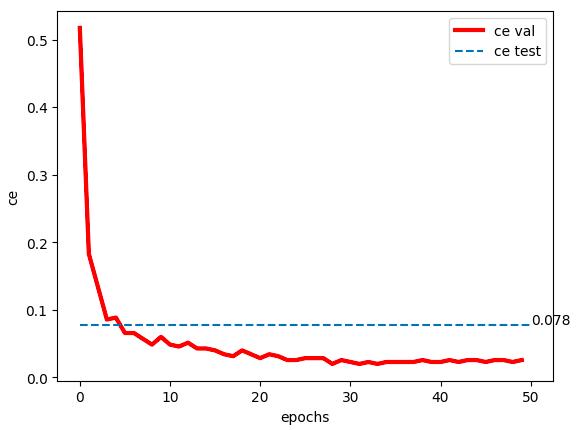

#### CNN

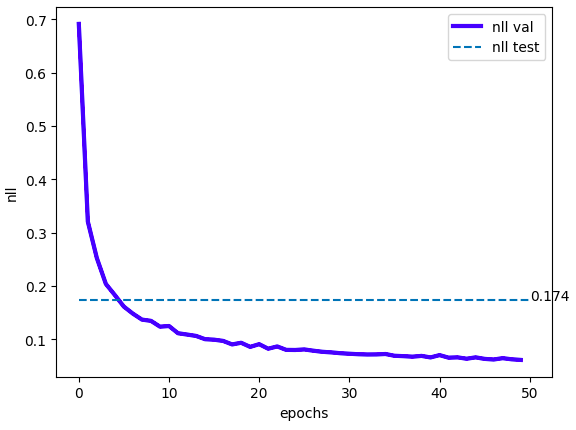

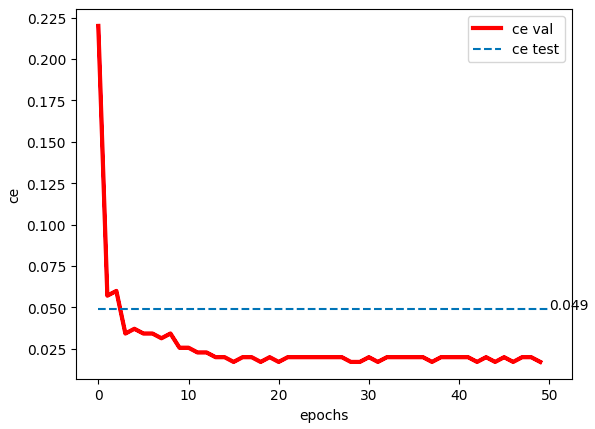

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: Yes, in general, Convolutional Neural Networks (CNNs) are better suited for image processing tasks than Multilayer Perceptrons (MLPs) due to several reasons:

Local Connectivity: CNNs mimic the way human vision works by focusing on local, neighboring pixels which carry more meaningful information for images.

Translation Invariance: CNNs recognize patterns regardless of their position in the image, unlike MLPs.

Dimensionality Reduction: CNNs use pooling layers to reduce computational complexity and prevent overfitting, a feature not present in MLPs.

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

3. the adamax optimiser, this can be useful with Sparse gradients: The gradients in a neural 
network can be sparse, which means they have numerous zero or 
near-zero values. Adamax can handle sparse gradients more successfully than Adam 
by scaling the gradients using the L-infinity norm (max norm),
which prevents learning rates from getting too tiny.

4. Data Loading and Transformation:

The SVHN dataset is loaded from MATLAB files using the scipy.io module. The data is then divided into training, validation, and test sets. ToTensor transformations are applied to the data.

Regarding the model architecture, a CNN is utilized with the following structure:

Convolutional layer 1: It has 3 input channels, 32 output channels, a kernel size of 3x3, and ReLU activation.
Max pooling layer 1: It employs a kernel size of 2x2 and a stride of 2.
Convolutional layer 2: It takes 32 input channels, produces 64 output channels, uses a kernel size of 3x3, and employs ReLU activation.
Max pooling layer 2: It uses a kernel size of 2x2 and a stride of 2.
Flatten layer.
Fully connected layer: It consists of 10 output neurons.
LogSoftmax layer.
The model is initialized using the specified architecture. The Adamax optimizer is employed with a predetermined learning rate and weight decay for optimization.

During the training loop, a custom training function is utilized to train the model. The training loss (NLL) and error are computed and stored.

For evaluation, a custom evaluation function is used to assess the trained model's performance on the test set. The test loss (NLL) and error are computed.

Results are written to files, and visualizations of the training and validation curves are generated.

In summary, this code sets up the SVHN dataset, defines a CNN architecture, trains the model, evaluates it on the test set, and generates result files and visualizations.

5. 
There is definitely scope for enhancing our findings, particularly in relation 
to the accuracy of matching house numbers with their corresponding labels. 
Examining our loss values provides a valuable avenue for improvement. 
Our primary objective during the model training phase is to minimize the loss, 
which directly impacts the accuracy. The negative log-likelihood loss is relatively insignificant, indicating that the network is highly confident in correctly classifying the data, resulting in a low loss. However, despite the network's impressive performance in terms of loss and reasonably accurate feature assignment, there is still untapped potential for further refinement. To address this, we can consider expanding our training dataset to incorporate a wider range of home numbers and descriptors. Although I am using a subset of around 2000 samples from the larger training dataset due to time constraints, this selection will still provide the model with diverse and representative samples to learn from. By doing so, we can improve its generalization capability and enable accurate predictions on unseen instances.



In [123]:
import scipy.io as io
import torchvision as tv
import numpy as np

from torchvision import datasets, transforms, models
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split, Dataset, DataLoader
from torch.utils.data import Dataset


In [124]:
train_data_file = "/content/drive/MyDrive/university CI/train_32x32.mat"
test_data_file = "/content/drive/MyDrive/university CI/test_32x32.mat"


In [130]:

class SVHNData(tv.datasets.SVHN):
    def __init__(self, mode='train', transforms=None):
        self.data, self.targets = self.load_data(mode)
        self.transforms = transforms

    def load_data(self, mode):
        if mode in ['train', 'val']:
            data = io.loadmat(train_data_file)
        else:
            data = io.loadmat(test_data_file)

        X = data['X'].transpose(3, 0, 1, 2)
        y = data['y'].astype(np.compat.long)
        y = [i[0] if i[0] != 10 else 0 for i in y]  # Fixes issue with 0 having the label 10 and not being co
        if mode == 'train':
            return X[:1000], y[:1350]
        elif mode == 'val':
            return X[1000:1350], y[1000:1350]
        else:
            return X, y

    def __getitem__(self, idx):
        sample_x, sample_y = self.data[idx], self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return sample_x, sample_y

# Initialize data loaders.
data_transforms = tv.transforms.Compose([tv.transforms.ToTensor()])

train_data = SVHNData(mode='train', transforms=data_transforms)
val_data = SVHNData(mode='val', transforms=data_transforms)
test_data = SVHNData(mode='test', transforms=data_transforms)

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

torch.autograd.set_detect_anomaly(True)


In [131]:

# Data hyperparameters
D = 256  # Input dimension

# Model hyperparameters
K = 10  # Number of labels
num_kernels = 64  # Number of kernels for CNN

# Training hyperparameters
lr = 1e-3  # Learning rate
wd = 1e-5  # Weight decay
num_epochs = 1000  # Maximum number of epochs
channels = 3


Epoch: 0, val nll=2.2078757803780693, val ce=0.7828571428571428
Epoch: 10, val nll=2.1249099731445313, val ce=0.78
Epoch: 20, val nll=1.8180988638741629, val ce=0.5771428571428572
Epoch: 30, val nll=1.4265153830392021, val ce=0.44285714285714284
Epoch: 40, val nll=1.2460230582101004, val ce=0.42
Epoch: 50, val nll=1.197517340523856, val ce=0.3657142857142857
Epoch: 60, val nll=1.1958688245500837, val ce=0.38571428571428573
Epoch: 70, val nll=1.2312664249965122, val ce=0.36857142857142855
Epoch: 80, val nll=1.2730608149937221, val ce=0.36
-> FINAL PERFORMANCE: nll=1.3788266309434531, ce=0.3824139520590043


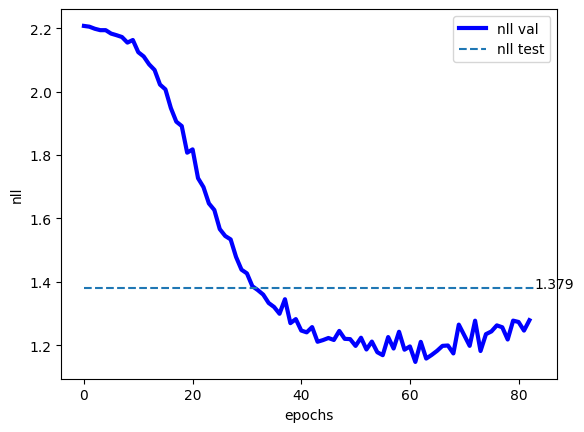

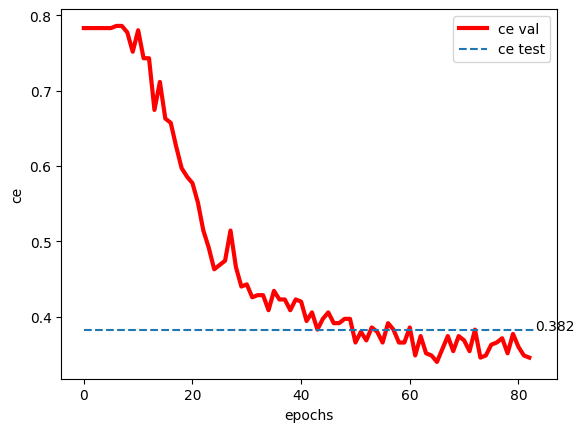

In [132]:
classnet = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: 32 x 16 x 16
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: 64 x 8 x 8
    nn.Flatten(),
    nn.Linear(64*8*8, 10),
    nn.LogSoftmax(dim=1)
)


# Init ClassifierNN
model = ClassifierNeuralNet(classnet)

# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad == True],
    lr=lr,
    weight_decay=wd
)

# Training procedure
nll_val, error_val = training(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader
)

# The final evaluation (on the test set)
test_loss, test_error = evaluation(
    name=result_dir + name,
    test_loader=test_loader
)

# Write the results to a file
f = open(result_dir + name + '_test_loss.txt', "w")
f.write('NLL: ' + str(test_loss) + '\nCE: ' + str(test_error))
f.close()

# Create curves
plot_curve(
    result_dir + name,
    nll_val,
    file_name='_nll_val_curve.pdf',
    ylabel='nll',
    test_eval=test_loss
)

plot_curve(
    result_dir + name,
    error_val,
    file_name='_ca_val_curve.pdf',
    ylabel='ce',
    color='r-',
    test_eval=test_error
)


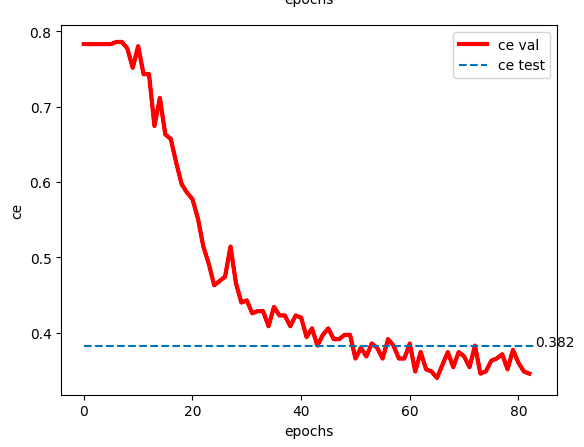